In [1]:
import GPy

In [2]:
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy
from IPython.display import display

In [3]:
X = np.array([[3, 2], [1, 4], [1, 1], [3, 4], [2,2], [2, 3], [3, 1], [3, 3.5], [2.5, 3.5]])
y = np.array([1, 1, 3, 2, 5.5, 4.5, 0.5, 3, 3.5])

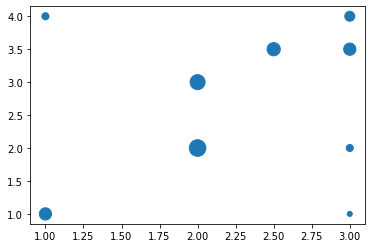

In [4]:
plt.scatter(X[:,0], X[:, 1],s=y*50)

In [5]:
k_2d = GPy.kern.RBF(input_dim=2, lengthscale=1)

In [6]:
m = GPy.models.GPRegression(X, y.reshape(-1, 1), k_2d)
m.optimize()

In [7]:
m

GP_regression.,value,constraints,priors
rbf.variance,6.275235283523973,+ve,
rbf.lengthscale,1.0831299030634542,+ve,
Gaussian_noise.variance,5.900692488985633e-07,+ve,


In [8]:
x_t = np.linspace(0, 4.5, 40)
y_t = np.linspace(0, 4.5, 40)

XX, YY = np.meshgrid(x_t, y_t)

In [9]:
Z_pred = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_pred[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1, 2))[0]

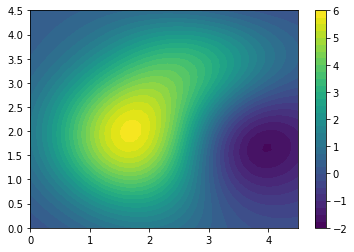

In [10]:
plt.contourf(XX, YY, Z_pred, levels=30)
plt.colorbar()

In [11]:
k_2d_ARD = GPy.kern.RBF(input_dim=2, lengthscale=1, ARD=True)

In [12]:
m = GPy.models.GPRegression(X, y.reshape(-1, 1), k_2d)
m.optimize()

In [13]:
m

GP_regression.,value,constraints,priors
rbf.variance,6.2752887369734855,+ve,
rbf.lengthscale,1.0831362619725815,+ve,
Gaussian_noise.variance,7.610103008628963e-08,+ve,


In [14]:
Z_pred = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_pred[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1, 2))[0]

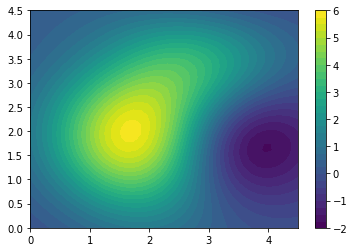

In [15]:
plt.contourf(XX, YY, Z_pred, levels=30)
plt.colorbar()

In [16]:
m.flattened_parameters

[GP_regression.rbf.variance:
 Param([6.27528874]),
 GP_regression.rbf.lengthscale:
 Param([1.08313626]),
 GP_regression.Gaussian_noise.variance:
 Param([7.61010301e-08])]

In [17]:
m.parameters[0].lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.08313626,+ve,


In [47]:
import deepgp
offset = y.mean()
scale = np.sqrt(y.var())
yhat = (y-offset)/scale
layers = [1, 1,X.shape[1]]
inits = ['PCA']*(len(layers)-1)
kernels = []
for i in layers[1:]:
    kernels += [GPy.kern.RBF(i, ARD=True)]
    
m = deepgp.DeepGP(layers,Y=yhat.reshape(-1, 1), X=X, 
                  inits=inits, 
                  kernels=kernels, # the kernels for each layer
                  num_inducing=4, back_constraint=False)

In [48]:
m.optimize()

In [49]:
m

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(4, 1)",,
obslayer.rbf.variance,2.4739959446628804e-09,+ve,
obslayer.rbf.lengthscale,4.44724245523993,+ve,
obslayer.Gaussian_noise.variance,0.9999855420359375,+ve,
obslayer.Kuu_var,"(4,)",+ve,
obslayer.latent space.mean,"(9, 1)",,
obslayer.latent space.variance,"(9, 1)",+ve,
layer_1.inducing inputs,"(4, 2)",,
layer_1.rbf.variance,1.6617209510002127e-13,+ve,
layer_1.rbf.lengthscale,"(2,)",+ve,


In [50]:
Z_pred = np.zeros_like(YY)
for i in range(40):
    for j in range(40):
        Z_pred[i, j] = m.predict(np.array([XX[i, j], YY[i, j]]).reshape(1, 2))[0]

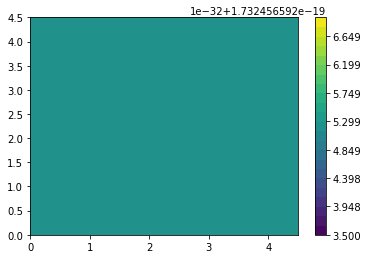

In [51]:
plt.contourf(XX, YY, Z_pred, levels=30)
plt.colorbar()

In [46]:
Z_pred

array([[-1.78756566e-18, -1.78756566e-18, -1.78756566e-18, ...,
        -1.78756566e-18, -1.78756566e-18, -1.78756566e-18],
       [-1.78756566e-18, -1.78756566e-18, -1.78756566e-18, ...,
        -1.78756566e-18, -1.78756566e-18, -1.78756566e-18],
       [-1.78756566e-18, -1.78756566e-18, -1.78756566e-18, ...,
        -1.78756566e-18, -1.78756566e-18, -1.78756566e-18],
       ...,
       [-1.78756566e-18, -1.78756566e-18, -1.78756566e-18, ...,
        -1.78756566e-18, -1.78756566e-18, -1.78756566e-18],
       [-1.78756566e-18, -1.78756566e-18, -1.78756566e-18, ...,
        -1.78756566e-18, -1.78756566e-18, -1.78756566e-18],
       [-1.78756566e-18, -1.78756566e-18, -1.78756566e-18, ...,
        -1.78756566e-18, -1.78756566e-18, -1.78756566e-18]])